<a href="https://colab.research.google.com/github/kathisw/hemophilia/blob/main/Hemophilia_Logistic_Regression_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hemophilia Logistic Regression Classification

In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from google.colab import files
from io import BytesIO


### Upload both CHBMP and CHAMP Excel files

Data loading from Excel

In [2]:

uploaded = files.upload()
file_names = list(uploaded.keys())
chbmp_df = pd.read_excel(BytesIO(uploaded[file_names[0]]), sheet_name=1)
champ_df = pd.read_excel(BytesIO(uploaded[file_names[1]]), sheet_name=1)


Saving CHAMP-Variant-List-2022 (3).xlsx to CHAMP-Variant-List-2022 (3).xlsx
Saving CHBMP-Variant-List-2022 (3).xlsx to CHBMP-Variant-List-2022 (3).xlsx


### Filter and prepare label column

Data cleaning

In [9]:

def clean_data(df, dataset_name):
    df = df.copy()
    df['Dataset'] = dataset_name
    df = df[df['History of Inhibitor'].isin(['Yes', 'No'])]
    df['Inhibitor_History_Binary'] = df['History of Inhibitor'].map({'Yes': 1, 'No': 0})
    return df

chbmp_df = clean_data(chbmp_df, 'CHBMP')
champ_df = clean_data(champ_df, 'CHAMP')
combined_df = pd.concat([chbmp_df, champ_df], ignore_index=True)


### Select features and label

In [15]:
X_encoded = X_encoded.astype(int)


In [16]:

features = ['Variant Type', 'Mechanism', 'Exon', 'Codon', 'Domain']
label = 'Inhibitor_History_Binary'
X = combined_df[features]
y = combined_df[label]


### Separate numeric and categorical features

### Fill missing values

In [17]:

features_numeric = []
features_categorical = []

for col in X.columns:
    if X[col].dtype == 'object':
        features_categorical.append(col)
    else:
        features_numeric.append(col)

# Fill missing values
X[features_numeric] = X[features_numeric].fillna(X[features_numeric].mean())
for col in features_categorical:
    X[col] = X[col].fillna(X[col].mode()[0])


<ipython-input-17-bbcae606be97>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(X[col].mode()[0])


### One-hot encoding of categorical features, splitting and SMOTE

In [21]:

# One-hot encoding
X_encoded = pd.get_dummies(X, columns=features_categorical)

# Convert booleans (True/False) to integers (1/0)
X_encoded = X_encoded.astype(int)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)



In [22]:
# Before applying SMOTE, convert boolean columns to integers:
for column in X_train.select_dtypes(include=['bool']).columns:
    X_train[column] = X_train[column].astype(int)

In [23]:

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_resampled.value_counts().to_dict())


Before SMOTE: {0: 1714, 1: 401}
After SMOTE: {0: 1714, 1: 1714}


### Train logistic regression model

In [24]:

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_resampled, y_train_resampled)
y_pred = clf.predict(X_test)


### Evaluate the model

In [25]:

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7277882797731569

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       429
           1       0.35      0.52      0.42       100

    accuracy                           0.73       529
   macro avg       0.61      0.65      0.62       529
weighted avg       0.78      0.73      0.75       529



The model achieved an accuracy of **~72.8%**, meaning that out of all predictions, nearly 73% were correct. However, in class-imbalanced scenarios like this (more “No Inhibitor” than “Yes Inhibitor”), accuracy alone can be misleading — so we also look at other metrics.


- **Class 0 (No Inhibitor)**:
  - Precision: 0.87 → When the model predicts “No Inhibitor,” it's correct 87% of the time.
  - Recall: 0.78 → It correctly identifies 78% of actual “No Inhibitor” cases.
  
- **Class 1 (Yes Inhibitor)**:
  - Precision: 0.35 → When it predicts “Yes Inhibitor,” it’s correct 35% of the time.
  - Recall: 0.52 → It detects 52% of all true inhibitor cases.


### Confusion Matrix

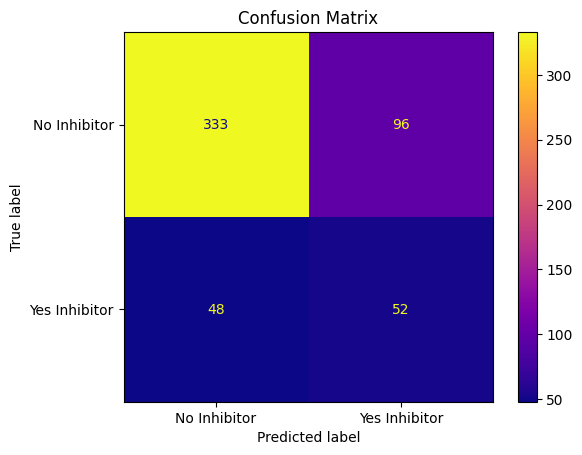

In [26]:

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Inhibitor', 'Yes Inhibitor'])
disp.plot(cmap='plasma')
plt.grid(False)
plt.title("Confusion Matrix")
plt.show()


#ROC and PR curves

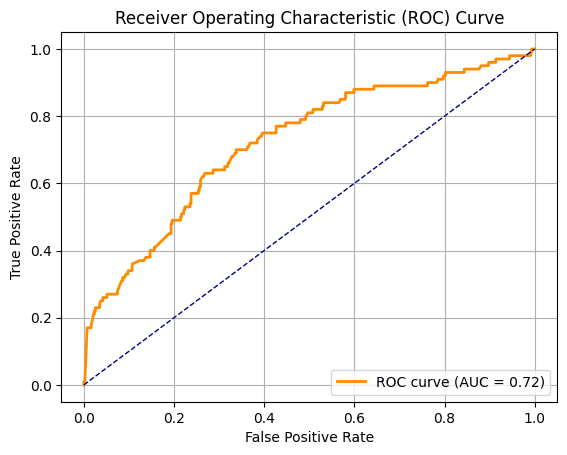

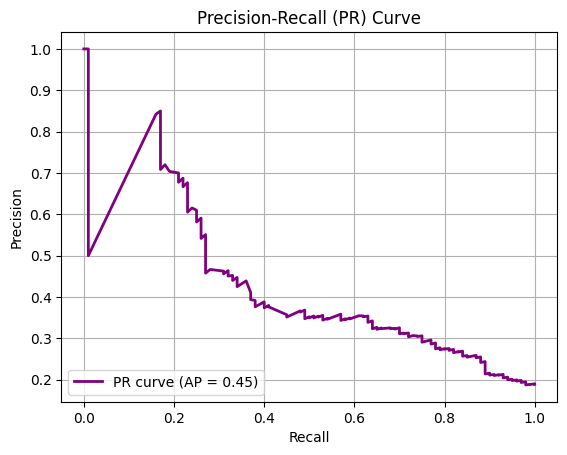

In [27]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Predict probabilities for ROC/PR curves
y_pred_prob = clf.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
avg_precision = average_precision_score(y_test, y_pred_prob)

plt.figure()
plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


### ✅ ROC Curve (AUC = 0.72)
The ROC (Receiver Operating Characteristic) curve shows how well the model distinguishes between classes.  
- **AUC = 0.72** means there’s a 72% chance the model ranks a random positive (inhibitor) case higher than a negative one.  
- This indicates **fair** discrimination ability — better than random, but there is room to improve.


### ✅ Precision-Recall (PR) Curve
The PR curve is especially useful for **imbalanced datasets** like this one.
- It shows how precision and recall trade off.
- In our case, the model finds **over half** of the inhibitor cases (52% recall), though precision is lower.
- The curve confirms that **the model is learning useful signals about the rare inhibitor class**.
